In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import string
import random
import timeit
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from tqdm.auto import tqdm

from IPython.display import HTML,display
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import nltk

import tqdm
import torch
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [2]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def clean_text(text):
    stop = stopwords.words('english')       
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

def apply_cleaning(X_train):
    
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):

    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):

    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):
   
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khoxh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\khoxh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
train = pd.read_csv("train.csv")
train["text"] = apply_cleaning(train["text"])
test = pd.read_csv(("test.csv"))
test["text"] = apply_cleaning(test["text"])

In [6]:
from sklearn.model_selection import GridSearchCV
X_train = train["text"]
y_train = train["sentiment"]
X_test = test["text"]
y_test = test["sentiment"]

# Create the Naive Bayes pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])


param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False], 
    'classifier__alpha': [0.1, 1.0, 10.0] 
}

    
# Create a GridSearchCV object for each pipeline
grid_search= GridSearchCV(pipeline, param_grid, cv=3, verbose=3)


# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy score for the current slice
score = accuracy_score(y_test, y_pred)

# Print the accuracy score and best hyperparameters for the current slice
print("Accuracy score: ", score)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1);, score=0.685 total time=   0.1s
[CV 2/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1);, score=0.697 total time=   0.1s
[CV 3/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1);, score=0.674 total time=   0.2s
[CV 1/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2);, score=0.668 total time=   0.6s
[CV 2/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2);, score=0.665 total time=   0.6s
[CV 3/3] END classifier__alpha=0.1, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2);, score=0.673 total time=   0.5s
[CV 1/3] END classifier__alpha=0.1, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1);, score=0.673 total time=   0.2s
[CV 2/3] END classifier__alpha=0.1, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1);, 

In [7]:
grid_search.best_params_

{'classifier__alpha': 0.1,
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 1)}

In [8]:
#!pip install --upgrade evaluate==0.4.1


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       117
           1       1.00      0.03      0.05       302
           2       0.66      1.00      0.79       784

    accuracy                           0.66      1203
   macro avg       0.89      0.35      0.29      1203
weighted avg       0.78      0.66      0.53      1203



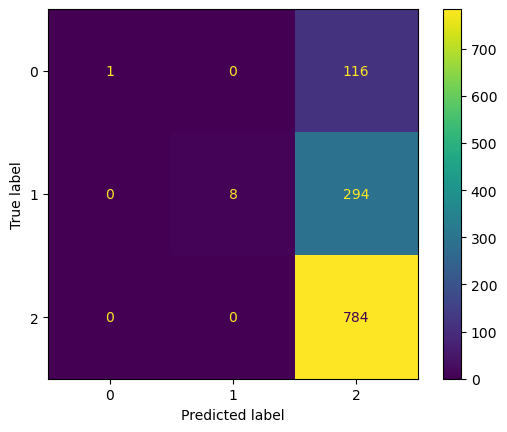

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import mmap
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('classifier', MultinomialNB(alpha=0.1,))
])

pipeline.fit(train["text"], train["sentiment"])

y_pred = pipeline.predict(test["text"])
pd.DataFrame(y_pred).to_csv("y_pred_tf-idf-NaiveBayes.csv")

def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    t1.plot()
    
evaluation_parametrics("Machine Learning Classification", y_test, y_pred)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.preprocessing import label_binarize

y_pred_probs = pipeline.predict_proba(test["text"])
pd.DataFrame(y_pred_probs).to_csv("y_pred_probs_tf-idf-NaiveBayes.csv")


NameError: name 'pipeline' is not defined

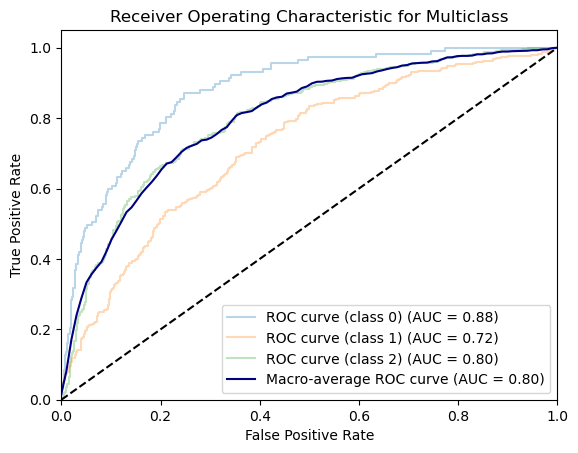

In [14]:
def evaluate_roc_probs(probs, y_true, average='micro'):

    n_classes = probs.shape[1]

    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro/macro-averaged ROC curve and ROC area
    if average == 'micro':
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)

        plt.plot(fpr_macro, tpr_macro, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro))
    
    elif average == 'macro':
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]), alpha=0.3)
        
        # Compute macro-average ROC curve and ROC area
        fpr_macro = np.linspace(0, 1, 100)
        tpr_macro = np.zeros_like(fpr_macro)
        for i in range(n_classes):
            tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
        tpr_macro /= n_classes
        roc_auc_macro = auc(fpr_macro, tpr_macro)
        
        plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro), color='navy')
    
    else:
        raise ValueError("Invalid value for 'average'. Use 'micro' or 'macro'.")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multiclass')
    plt.legend(loc="lower right")
    plt.show()

evaluate_roc_probs(y_pred_probs, test["sentiment"].values, average='macro')

In [13]:
# Generate predictions using the model and added to the DataFrame
test['y_pred'] = pipeline.predict(test["text"])

# Filter test set where model failed to predict the label correctly
failed_predictions = test[test["sentiment"] != test["y_pred"]]

# Sample 5 random observations from the filtered set
random_failed_samples = failed_predictions.sample(5, random_state=42)

pd.set_option('display.max_colwidth', None)
print(random_failed_samples)


                                                                                                                                                                                                                                                                                                                                                    text  \
488                                                                                                                                                                                                              i honestly tell making difference whole skincare routine better general but overall i think good cleanser continued use least last year   
387                                                                                                                                                                                                                                                                                          love dermalogica pr